# Task1 数据读取与分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train.csv', sep='\t', header=None, names=['text', 'label'])
df_train.head()

,text,label
0,还有双鸭山到淮阴的汽车票吗13号的,Travel-Query
1,从这里怎么回家,Travel-Query
2,随便播放一首专辑阁楼里的佛里的歌,Music-Play
3,给看一下墓王之王嘛,FilmTele-Play
4,我想看挑战两把s686打突变团竞的游戏视频,Video-Play


FilmTele-Play            1355
Video-Play               1334
Music-Play               1304
Radio-Listen             1285
Alarm-Update             1264
Weather-Query            1229
Travel-Query             1220
HomeAppliance-Control    1215
Calendar-Query           1214
TVProgram-Play            240
Audio-Play                226
Other                     214
Name: label, dtype: int64


<AxesSubplot: xlabel='label', ylabel='count'>

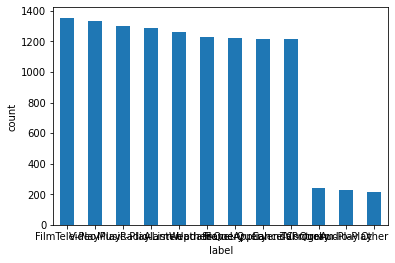

In [3]:
print(df_train['label'].value_counts())
df_train['label'].value_counts().plot(kind='bar', xlabel='label', ylabel='count', rot=0)

<AxesSubplot: ylabel='Frequency'>

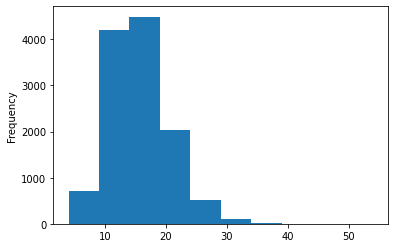

In [4]:
# print(df_train['text'].apply(len).value_counts())
df_train['text'].str.len().plot.hist()

In [5]:
df_test = pd.read_csv('test.csv', sep='\t', header=None, names=['text', 'label'])
df_test.head()

,text,label
0,回放CCTV2的消费主张,NaN
1,给我打开玩具房的灯,NaN
2,循环播放赵本山的小品相亲来听,NaN
3,15号上午10点带孩子去海洋馆的行程帮我制定下。,NaN
4,把智能扫地机器人关掉,NaN


<AxesSubplot: ylabel='Frequency'>

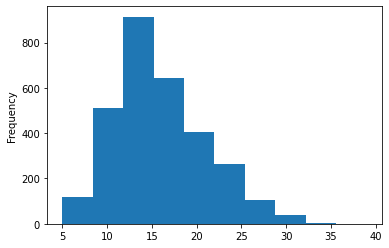

In [6]:
# print(df_train['text'].apply(len).value_counts())
df_test['text'].str.len().plot.hist()

可以看出在训练集中，类别分布上TVProgram-play, Audio-play和other数量较少且接近，剩余的类别数量接近。测试集没有标签无法知道对应分布。  
文本长度上，训练集和测试集的分布较为一致，基本集中在5-35字之间，且10-25字分布最多，属于短文本。

In [7]:
from sklearn.model_selection import train_test_split

df_train,df_valid = train_test_split(df_train, test_size=0.2)

In [8]:
print(df_train.shape)
print(df_valid.shape)

(9680, 2)
(2420, 2)


# Task 5

In [9]:
import torch 
import numpy as np
from transformers import BertTokenizer

print(torch.cuda.is_available())

D:\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [10]:
tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
label_array = df_train['label'].unique()
labels = list(range(len(label_array)))
labels = {category: label for category, label in zip(label_array, labels)}
print(labels)

{'Alarm-Update': 0, 'Video-Play': 1, 'Weather-Query': 2, 'HomeAppliance-Control': 3, 'Travel-Query': 4, 'Calendar-Query': 5, 'Music-Play': 6, 'FilmTele-Play': 7, 'Radio-Listen': 8, 'TVProgram-Play': 9, 'Other': 10, 'Audio-Play': 11}


In [11]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 64, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [12]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('hfl/chinese-bert-wwm')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 12)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [13]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
early_stop = EarlyStopping(patience=3,verbose=True)

In [14]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=8)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    
            early_stop(total_loss_val/len(val_data), model)
            if early_stop.early_stop:
                print('early stopping')
                break
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 10
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_valid, LR, EPOCHS)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:34<00:00, 12.80it/s]


Validation loss decreased (inf --> 0.107585).  Saving model ...
Epochs: 1 | Train Loss:  0.201                 | Train Accuracy:  0.599                 | Val Loss:  0.108                 | Val Accuracy:  0.803


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.15it/s]


Validation loss decreased (0.107585 --> 0.044065).  Saving model ...
Epochs: 2 | Train Loss:  0.064                 | Train Accuracy:  0.892                 | Val Loss:  0.044                 | Val Accuracy:  0.919


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:31<00:00, 13.17it/s]


Validation loss decreased (0.044065 --> 0.034433).  Saving model ...
Epochs: 3 | Train Loss:  0.035                 | Train Accuracy:  0.937                 | Val Loss:  0.034                 | Val Accuracy:  0.932


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.07it/s]


Validation loss decreased (0.034433 --> 0.029407).  Saving model ...
Epochs: 4 | Train Loss:  0.024                 | Train Accuracy:  0.959                 | Val Loss:  0.029                 | Val Accuracy:  0.937


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.09it/s]


Validation loss decreased (0.029407 --> 0.027763).  Saving model ...
Epochs: 5 | Train Loss:  0.017                 | Train Accuracy:  0.975                 | Val Loss:  0.028                 | Val Accuracy:  0.940


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.14it/s]


EarlyStopping counter: 1 out of 3
Epochs: 6 | Train Loss:  0.013                 | Train Accuracy:  0.983                 | Val Loss:  0.028                 | Val Accuracy:  0.943


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.07it/s]


Validation loss decreased (0.027763 --> 0.027165).  Saving model ...
Epochs: 7 | Train Loss:  0.009                 | Train Accuracy:  0.989                 | Val Loss:  0.027                 | Val Accuracy:  0.940


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.08it/s]


EarlyStopping counter: 1 out of 3
Epochs: 8 | Train Loss:  0.007                 | Train Accuracy:  0.992                 | Val Loss:  0.028                 | Val Accuracy:  0.941


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.10it/s]


EarlyStopping counter: 2 out of 3
Epochs: 9 | Train Loss:  0.005                 | Train Accuracy:  0.995                 | Val Loss:  0.029                 | Val Accuracy:  0.941


100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [01:32<00:00, 13.07it/s]


EarlyStopping counter: 3 out of 3
early stopping


In [ ]:
checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()